# Preprocesamiento

Para responder las hipótesis planteadas se consideraron solamente las tablas de posts, usuarios y tags, eliminando las columnas de identificadores de las tablas  y ejecutando un query se obtuvieron nuevos atributos que se indican acontinuación. 

**1. Características del usuario que responde**

Con la finalidad de determinar la influencia de la reputación y experiencia del usuario que plantea la pregunta se proponen las siguientes características:

El tiempo de respuesta partir de la fecha de creación del post, para ello se utilizaron los atributos: **post_creation_date** y **ans_creation_date** y el resultado es **time_answer**.

* **user_numans**: número de respuestas previo.
* **user_numans_accepted** número de respuestas aceptadas.

Para obtener estos atributos se eliminaron aquellos post que no tienen usuario registrado.

**2. Características de la respuesta**

Además se obtuvieron características del cuerpo dela respuesta  **ans_body**:

* **num_block_code**: cantidad de bloques de código considerando el tag "pre"
* **code_lenght**: número de caracteres en los bloques de código
* **num_i_sentences**: número de oraciones que empiezan con “I”
* **num_wh_words**: número de oraciones que empiezan con  una pregunta. (How, What, etc.)
* **num_words**: número de palabras en el post, eliminando las "top words"
* **num_y_sentences**: número de oraciones que empiezan con “You”. Post que contienen una explicación previa.
* **num_url**: número de links en la respuesta.

Adicionalmente se mantienen algunas de las características obtenidas del dataset como:
* **ans_comment_count**: cantidad de comentarios de la respuesta.
* **post_comment_count**: cantidad de comentarios del post.
* **post_answer_count**: cantidad de respuestas del post.
* **post_view_count**: cantidad de vistas del post.
* **post_favorite_count**: cantidad de marcas como favorito del post.
* **post_score**: score del post.


In [1]:
from bs4 import BeautifulSoup
import pandas as pd

df=pd.read_csv("res-1.csv", usecols=['ans_scoreclass','ans_score','ans_body','ans_comment_count',
    'ans_creation_date','post_comment_count','post_creation_date','post_answer_count',
    'post_view_count','post_favorite_count','post_score','user_numans', 'user_numans_accepted'], quotechar='"')
df.dropna() 
df['post_creation_date']=pd.to_datetime(df['post_creation_date'])
df['ans_creation_date']=pd.to_datetime(df['ans_creation_date'])

In [142]:
df.head()
df.describe()

,ans_comment_count,ans_score,ans_scoreclass,post_comment_count,post_answer_count,post_favorite_count,post_view_count,post_score,user_numans,user_numans_accepted
count,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.000000
mean,3.337476,54.064810,2.000000,2.193857,6.169667,36.192381,6.017503e+04,78.926762,1053.951048,527.317000
std,4.280074,152.443592,2.000048,3.200700,17.680338,243.330985,1.819528e+05,349.334313,3367.928472,1955.888721
min,0.000000,-28.000000,-1.000000,0.000000,1.000000,0.000000,7.000000e+00,-45.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,6.570000e+02,1.000000,25.000000,6.000000
50%,2.000000,15.000000,2.000000,1.000000,3.000000,3.000000,1.068250e+04,14.000000,124.000000,40.000000
75%,5.000000,57.000000,4.000000,3.000000,6.000000,16.000000,4.911175e+04,53.000000,592.000000,239.000000
max,69.000000,7195.000000,5.000000,51.000000,518.000000,5822.000000,5.241108e+06,15093.000000,37988.000000,20898.000000


In [143]:
df2 = pd.DataFrame(data=df, index=df.index, columns=['ans_scoreclass','ans_comment_count'
    ,'post_comment_count','post_answer_count','post_view_count',
    'post_favorite_count','post_score','user_numans','user_numans_accepted'])
df2.head()

,ans_scoreclass,ans_comment_count,post_comment_count,post_answer_count,post_view_count,post_favorite_count,post_score,user_numans,user_numans_accepted
0,-1,2,2,2,142,0,1,1,0
1,-1,0,15,1,74,1,-1,2,0
2,-1,1,0,2,178,0,1,12,1
3,-1,1,0,3,22,0,0,30,5
4,-1,1,0,1,887,0,1,771,274


In [144]:
from nltk.corpus import stopwords


#Edad de creacion de la cuenta en relacion al post en dias.
df2['time_answer'] = (df['ans_creation_date'] - df['post_creation_date']).fillna(0).astype('timedelta64[D]')
df2['num_block_code'] = 0
df2["num_i_sentences"]=0
df2["num_wh_words"]=0
df2["num_y_sentences"]=0

whwords=['what','how', 'which', 'when', 'why', 'where']
for index, row in df.iterrows():
    sbody=row["ans_body"]
    soup = BeautifulSoup(sbody, "html5lib")
    sentences =  soup.find_all(name="p")
    urls =  soup.find_all('a', href=True)
    #Questions words
    count_wh=0
    #Oraciones que tienen el pronombre I
    count_is=0
    #Oraciones que tienen el pronombre You
    count_ys = 0
    palabras=[]
    filtered_words=[]
    for sentence in sentences:
        try:
            palabras=sentence.contents[0].split()
        except:
            palabras=str(sentence.contents).split() 
        if(len(palabras)==0):
            children = soup.find_all("li", { "class" : "expandable" }, recursive=False)
            for child in children:
                palabras.extend(child.getText().split())
        filtered_words.extend([word for word in palabras if word not in stopwords.words('english')])
        count_is=count_is+len([x for x in palabras if x == "I"])
        count_is=count_is+len([x for x in palabras if len(x.split("I'"))>1])    
        count_ys=count_ys+len([x for x in palabras if x == "You"])
        count_ys=count_ys+len([x for x in palabras if len(x.split("You'"))>1])
        for word in whwords:
            count_wh=count_wh+len([x for x in palabras if x == word])
    df2.loc[index, "num_i_sentences"] = count_is
    df2.loc[index, "num_wh_words"] = count_wh
    df2.loc[index, "num_y_sentences"] = count_ys    
    df2.loc[index, "num_words"] = len(filtered_words)
    df2.loc[index, "num_url"]=len(urls)

In [145]:
df2.head()

,ans_scoreclass,ans_comment_count,post_comment_count,post_answer_count,post_view_count,post_favorite_count,post_score,user_numans,user_numans_accepted,time_answer,num_block_code,num_i_sentences,num_wh_words,num_y_sentences,num_words,num_url
0,-1,2,2,2,142,0,1,1,0,0.0,0,0,0,0,17.0,0.0
1,-1,0,15,1,74,1,-1,2,0,0.0,0,0,0,1,6.0,2.0
2,-1,1,0,2,178,0,1,12,1,0.0,0,0,0,0,6.0,0.0
3,-1,1,0,3,22,0,0,30,5,0.0,0,0,0,0,5.0,0.0
4,-1,1,0,1,887,0,1,771,274,0.0,0,0,0,1,28.0,2.0


In [146]:
#Caracteristicas del codigo y tags
import string

for index, row in df.iterrows():
    body=row["ans_body"]
    soup = BeautifulSoup(body, "html5lib")
    precode = soup.find_all("pre")
    df2.loc[index, "num_block_code"]=len(precode)
    content=""
    for codeline in precode:
        contentPre = codeline.contents
        for contentCode in contentPre:
            try:
                content=content+contentCode.contents[0]
            except :
                try:
                    content = content + str(contentCode)
                except:
                    print(contentCode)
    wordCodeCount =len(content)
    df2.loc[index,"code_length"]=wordCodeCount    
df2.head()

,ans_scoreclass,ans_comment_count,post_comment_count,post_answer_count,post_view_count,post_favorite_count,post_score,user_numans,user_numans_accepted,time_answer,num_block_code,num_i_sentences,num_wh_words,num_y_sentences,num_words,num_url,code_length
0,-1,2,2,2,142,0,1,1,0,0.0,0,0,0,0,17.0,0.0,0.0
1,-1,0,15,1,74,1,-1,2,0,0.0,0,0,0,1,6.0,2.0,0.0
2,-1,1,0,2,178,0,1,12,1,0.0,0,0,0,0,6.0,0.0,0.0
3,-1,1,0,3,22,0,0,30,5,0.0,0,0,0,0,5.0,0.0,0.0
4,-1,1,0,1,887,0,1,771,274,0.0,1,0,0,1,28.0,2.0,303.0


In [147]:
num_features = [
 'ans_comment_count',
 'post_comment_count',
 'post_answer_count',
 'post_view_count',
 'post_favorite_count',
 'post_score',
 'user_numans',
 'user_numans_accepted',
 'time_answer',
 'num_block_code',
 'num_i_sentences',
 'num_wh_words',
 'num_y_sentences',
 'num_words',
 'num_url',
 'code_length']
df_statistics=pd.DataFrame(index=num_features)
for index, row in df_statistics.iterrows():
    df_statistics.loc[index,"min"]=df2[index].min()
    df_statistics.loc[index,"max"] = df2[index].max()
    df_statistics.loc[index,"mean"] = df2[index].mean()
    df_statistics.loc[index,"std"] = df2[index].std()
    df_statistics.loc[index,"var"] = df2[index].var()
df_statistics

,min,max,mean,std,var
ans_comment_count,0.0,69.0,3.337476,4.280074,1.831903e+01
post_comment_count,0.0,51.0,2.193857,3.200700,1.024448e+01
post_answer_count,1.0,518.0,6.169667,17.680338,3.125943e+02
post_view_count,7.0,5241108.0,60175.033667,181952.781945,3.310681e+10
post_favorite_count,0.0,5822.0,36.192381,243.330985,5.920997e+04
post_score,-45.0,15093.0,78.926762,349.334313,1.220345e+05
user_numans,0.0,37988.0,1053.951048,3367.928472,1.134294e+07
user_numans_accepted,0.0,20898.0,527.317000,1955.888721,3.825501e+06
time_answer,-661.0,3037.0,133.691238,363.741443,1.323078e+05
num_block_code,0.0,40.0,1.141571,1.499212,2.247636e+00


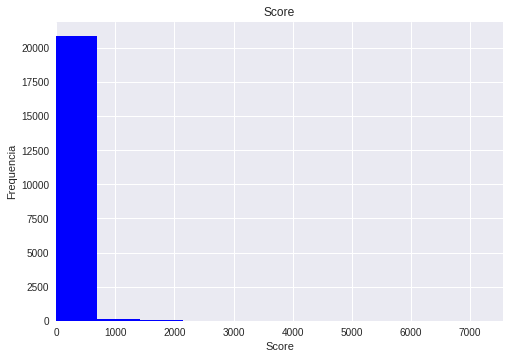

In [148]:
import matplotlib.pyplot as plt
plt.hist(df['ans_score'], bins=10, color="blue")
plt.xlim(xmin=0)
plt.title("Score")
plt.ylabel("Frequencia")
plt.xlabel("Score")
plt.show()

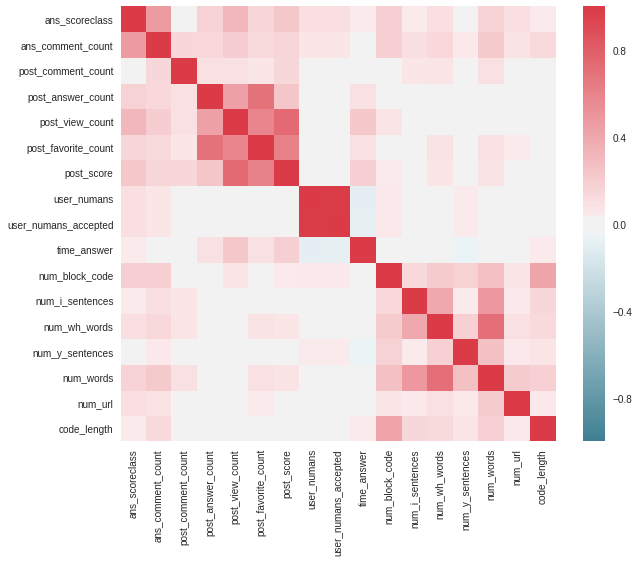

In [149]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
f, ax = plt.subplots(figsize=(10, 8))
corr = df2.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

In [150]:
for each in num_features:
    mean, std = df2[each].mean(), df2[each].std()
    df2.loc[:, each] = (df2[each] - mean)/std
df2.describe()

,ans_scoreclass,ans_comment_count,post_comment_count,post_answer_count,post_view_count,post_favorite_count,post_score,user_numans,user_numans_accepted,time_answer,num_block_code,num_i_sentences,num_wh_words,num_y_sentences,num_words,num_url,code_length
count,21000.000000,2.100000e+04,2.100000e+04,2.100000e+04,2.100000e+04,2.100000e+04,2.100000e+04,2.100000e+04,2.100000e+04,2.100000e+04,2.100000e+04,2.100000e+04,2.100000e+04,2.100000e+04,2.100000e+04,2.100000e+04,2.100000e+04
mean,2.000000,-2.312191e-14,-1.739275e-15,-3.404811e-14,-3.912928e-16,-6.668794e-15,8.045171e-15,-4.533834e-16,-5.033598e-15,-5.268696e-15,1.057866e-14,-2.813263e-15,-1.493386e-14,-2.567206e-16,-1.344863e-16,2.083878e-15,5.615006e-15
std,2.000048,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.000000,-7.797708e-01,-6.854305e-01,-2.923964e-01,-3.306794e-01,-1.487372e-01,-3.547512e-01,-3.129375e-01,-2.696048e-01,-2.184770e+00,-7.614477e-01,-4.049344e-01,-4.173195e-01,-4.934466e-01,-6.555868e-01,-2.485709e-01,-3.739451e-01
25%,0.000000,-7.797708e-01,-6.854305e-01,-2.358364e-01,-3.271070e-01,-1.487372e-01,-2.230722e-01,-3.055145e-01,-2.665371e-01,-3.675447e-01,-7.614477e-01,-4.049344e-01,-4.173195e-01,-4.934466e-01,-4.929657e-01,-2.485709e-01,-3.739451e-01
50%,2.000000,-3.124891e-01,-3.729988e-01,-1.792764e-01,-2.720076e-01,-1.364084e-01,-1.858585e-01,-2.761196e-01,-2.491537e-01,-3.675447e-01,-9.443057e-02,-4.049344e-01,-4.173195e-01,-4.934466e-01,-2.896893e-01,-2.485709e-01,-2.700060e-01
75%,4.000000,3.884335e-01,2.518646e-01,-9.596348e-03,-6.080305e-02,-8.298319e-02,-7.421762e-02,-1.371618e-01,-1.474097e-01,-3.565479e-01,5.725866e-01,3.267488e-01,4.346842e-01,-4.934466e-01,9.653598e-02,1.011771e-01,6.732040e-03
max,5.000000,1.534145e+01,1.524859e+01,2.894913e+01,2.847405e+01,2.377752e+01,4.297910e+01,1.096640e+01,1.041505e+01,7.981793e+00,2.591924e+01,2.520398e+01,2.258678e+01,1.658364e+01,2.495724e+01,1.011783e+02,2.888623e+01


In [151]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier


In [156]:
X = df2.iloc[:,1:]
y = df2.iloc[:,0]

clf=DecisionTreeClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=3000,random_state=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

         -1       0.39      0.37      0.38       450
          0       0.35      0.35      0.35       434
          1       0.36      0.37      0.36       419
          2       0.40      0.38      0.39       418
          3       0.36      0.38      0.37       433
          4       0.36      0.38      0.37       412
          5       0.60      0.60      0.60       434

avg / total       0.40      0.40      0.40      3000



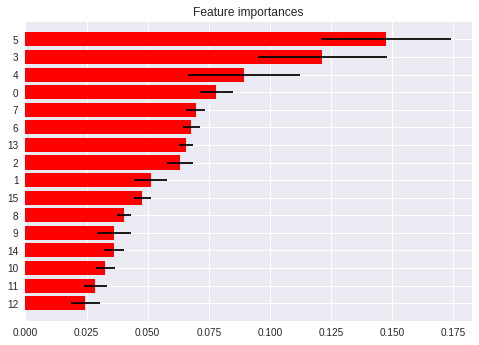

In [157]:
from sklearn.ensemble import ExtraTreesClassifier
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)

plt.figure()
plt.title("Feature importances")
plt.barh(range(X.shape[1]), importances[indices],
       color="r", xerr=std[indices], align="center")

plt.yticks(range(X.shape[1]), indices)
plt.ylim([-1, X.shape[1]])
plt.show()

In [158]:
list(df2)

['ans_scoreclass',
 'ans_comment_count',
 'post_comment_count',
 'post_answer_count',
 'post_view_count',
 'post_favorite_count',
 'post_score',
 'user_numans',
 'user_numans_accepted',
 'time_answer',
 'num_block_code',
 'num_i_sentences',
 'num_wh_words',
 'num_y_sentences',
 'num_words',
 'num_url',
 'code_length']